## Time Series Modeling

### Setup

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
%pip install m2cgen
%pip install pmdarima
%pip install scikit-learn==1.3.1
%pip install tensorflow_decision_forests

In [ ]:
import m2cgen as m2c
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import xgboost as xgb

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv", names=["value"], header=0)

### ARIMA

2 ways:
 - manual selection of parameters (data scientists)
 - automatic selection of parameters (engineers)

In [ ]:
model = pm.auto_arima(
  df.value,
  start_p=1,
  start_q=1,
  test="adf",
  max_p=3,
  max_q=3,
  m=1,
  d=None,
  seasonal=False,
  start_P=0,
  D=0,
  trace=True,
  error_action="ignore",
  suppress_warnings=True,
  stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.72 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.29 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=1.47 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.40 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.29 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.27 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.25 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(2, 2, 0)   Log Likelihood                -252.732
Date:                Thu, 30 Jan 2025   AIC                            511.465
Time:                        13:54:01   BIC                            519.220
Sample:                             0   HQIC                           514.601
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2579      0.103      2.510      0.012       0.056       0.459
ar.L2         -0.4407      0.087     -5.093      0.000      -0.610      -0.271
sigma2        10.1268      1.519      6.668      0.0

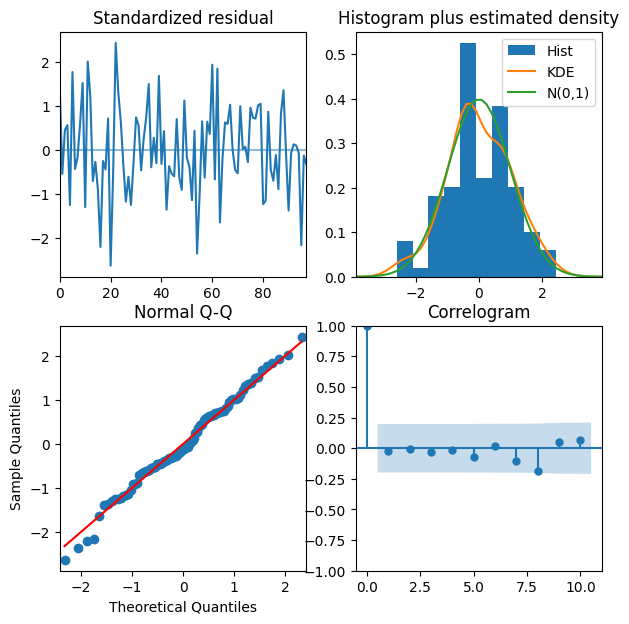

In [ ]:
model.plot_diagnostics(figsize=(7,7))
plt.show()

- Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

- Top Right: The density plot suggest normal distribution with mean zero.

- Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

- Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

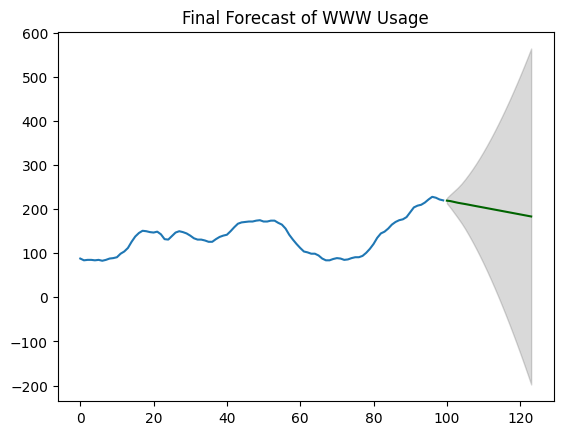

In [ ]:
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

plt.plot(df.value)
plt.plot(fc_series, color="darkgreen")
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color="k", alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

### SARIMA

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/a10.csv", parse_dates=["date"], index_col="date")

In [ ]:
smodel = pm.auto_arima(
    df,
    start_p=1,
    start_q=1,
    test='adf',
    max_p=3,
    max_q=3,
    m=12,
    start_P=0,
    seasonal=True,
    d=None,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=5.18 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.15 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=3.15 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=2.34 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.11 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=1.69 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=8.24 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=11.28 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=1.17 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.743, Time=7.93 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=1.51 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=1.14 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.32 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -254.036
Date:                            Thu, 30 Jan 2025   AIC                            524.072
Time:                                    13:56:43   BIC                            550.132
Sample:                                07-01-1991   HQIC                           534.627
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0052      0.009      0.559      0.576      -0.013       0.023
ar.L1          0.9755      0.019     52.230      0.000       0.939       1.012
ma.L1         -0.8952      0.057    -15.831      0.000      -1.006      -0.784
ma.L2          0.2065      0.058      3.585      0.000       0.094       0.319
ar.S.L12       0.8442      0.174      4.862      0.000       0.504       1.185
ma.S.L12      -1.5510      0.192     -8.097      0.000      -1.926      -1.176
ma.S.L24       0.7250      0.112      6.454      0.000       0.505       0.945
sigma2         0.7593      0.063     12.047      0.000       0.636       0.883
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):               143.35
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):              14.51   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

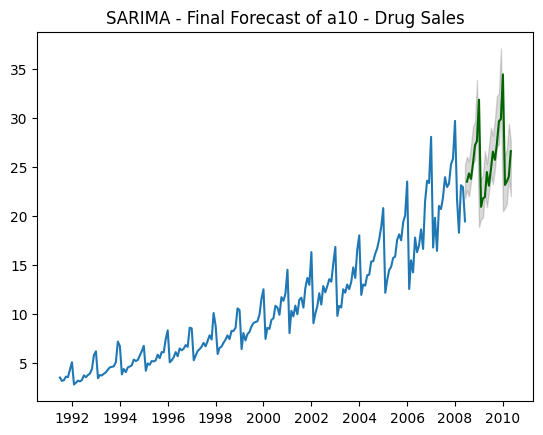

In [ ]:
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='MS')

fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

plt.plot(df)
plt.plot(fitted_series, color="darkgreen")
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color="k", alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

### Random Forest

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Projects/TsaWorkshop/temp_dataset.csv", parse_dates=True)
df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
df["moving_average"] = df["Hourly_Temp"].rolling(window=24).mean()
df["percentage"] = df["Hourly_Temp"].pct_change().mul(100)
df["lag_1"] = df["Hourly_Temp"].shift(periods=1)
df["lag_2"] = df["Hourly_Temp"].shift(periods=2)
df.dropna(inplace=True)

In [ ]:
df["Datetime"] = pd.to_datetime(df["Datetime"])
train = df[df["Datetime"] <= "2022-07-31"]
test = df[df["Datetime"] > "2022-07-31"]
X_train = train.drop("Hourly_Temp", axis=1)
X_test = test.drop("Hourly_Temp", axis=1)
y_train = train["Hourly_Temp"]
y_test = test["Hourly_Temp"]

In [ ]:
train["Datetime"] = (train["Datetime"] - train["Datetime"].min()).dt.total_seconds()
test["Datetime"] = (test["Datetime"] - test["Datetime"].min()).dt.total_seconds()

In [ ]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [ ]:
train.head()

,Datetime,Hourly_Temp,moving_average,percentage,lag_1,lag_2
0,0.0,21.800,21.064583,-2.242152,22.300,22.700
1,3600.0,21.333,21.084000,-2.142202,21.800,22.300
2,7200.0,20.933,21.081208,-1.875029,21.333,21.800
3,10800.0,20.567,21.068708,-1.748435,20.933,21.333
4,14400.0,20.250,21.052042,-1.541304,20.567,20.933


In [ ]:
test.head()

,Datetime,Hourly_Temp,moving_average,percentage,lag_1,lag_2
0,0.0,26.440,24.544333,0.658621,26.267,26.000
1,3600.0,26.343,24.622500,-0.366868,26.440,26.267
2,7200.0,25.900,24.694708,-1.681661,26.343,26.440
3,10800.0,25.343,24.754125,-2.150579,25.900,26.343
4,14400.0,25.233,24.801333,-0.434045,25.343,25.900


In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, task=tfdf.keras.Task.REGRESSION, label="Hourly_Temp", fix_feature_names=False)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, task=tfdf.keras.Task.REGRESSION, label="Hourly_Temp", fix_feature_names=False)

In [ ]:
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, num_trees=100, max_depth=10)
model.fit(x=train_ds)

Use /tmp/tmp8v778e5w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:05.099926. Found 4970 examples.
Training model...
Model trained in 0:00:00.661462
Compiling model...
Model compiled.


In [ ]:
prediction = model.predict(x=test_ds)

3/3 [==============================] - 0s 11ms/step


In [ ]:
prediction_series = pd.Series(prediction.flatten(), index=y_test.index)

Text(0.5, 1.0, 'Ground truth')

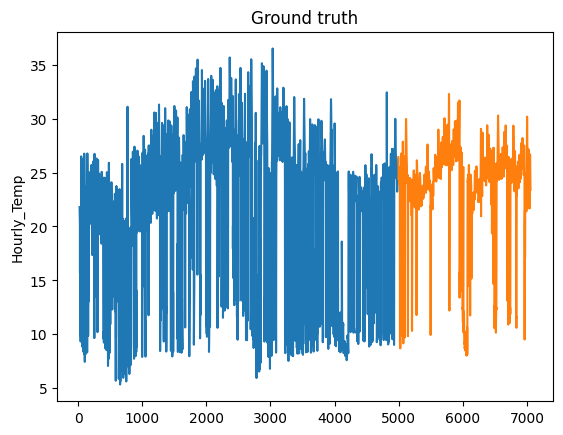

In [ ]:
sns.lineplot(y_train)
sns.lineplot(y_test)
plt.title("Ground truth")

Text(0.5, 1.0, 'Prediction with TF Decision Forest')

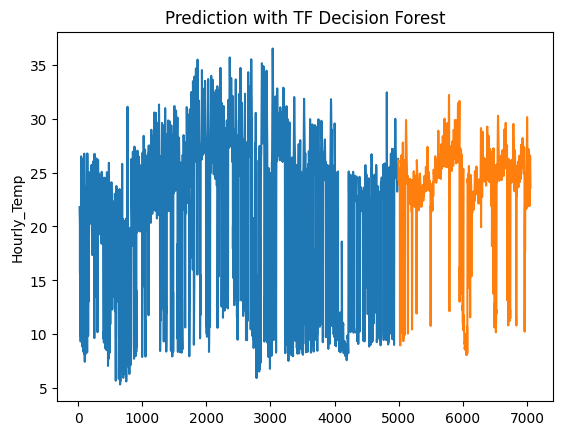

In [ ]:
sns.lineplot(y_train)
sns.lineplot(prediction_series)
plt.title("Prediction with TF Decision Forest")

In [ ]:
print(mean_squared_error(y_test, prediction_series))

0.04264591594739379


In [ ]:
model.save("/content/drive/MyDrive/Projects/TsaWorkshop/randomforest")

### XGBoost

In [ ]:
X_train["Datetime"] = (X_train["Datetime"] - X_train["Datetime"].min()).dt.total_seconds()
X_test["Datetime"] = (X_test["Datetime"] - X_test["Datetime"].min()).dt.total_seconds()

In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)

In [32]:
params = {
    "base_score": 0,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 6,
    "learning_rate": 0.1,
    "n_estimators": 60,
}

In [33]:
model = xgb.XGBRegressor(**params)

In [34]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0, booster=None, callbacks=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=60, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:
prediction = model.predict(X_test)

In [36]:
prediction_series = pd.Series(prediction, index=y_test.index)

Text(0.5, 1.0, 'Prediction with XGBoost')

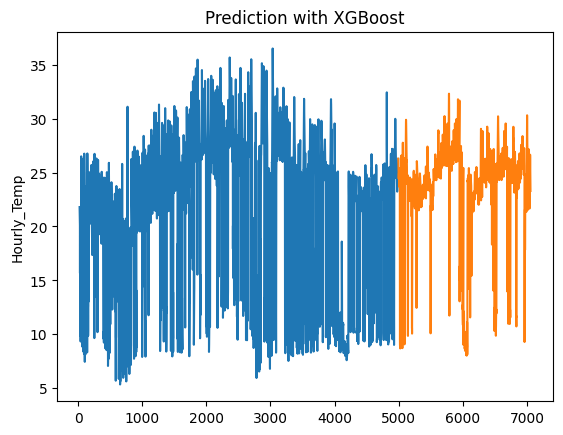

In [37]:
sns.lineplot(y_train)
sns.lineplot(prediction_series)
plt.title("Prediction with XGBoost")

In [38]:
rmse = mean_squared_error(y_test, prediction)
print(f"RMSE: {rmse}")

RMSE: 0.033536818403095046


In [39]:
model.save_model("/content/drive/MyDrive/Projects/TsaWorkshop/xgboost.json")

In [40]:
code = m2c.export_to_c(model)

In [41]:
with open("/content/drive/MyDrive/Projects/TsaWorkshop/XGBRegressor.h", "w") as file:
    file.write(code)

In [42]:
print(code)

double score(double * input) {
    double var0;
    if (input[3] < 20.933) {
        if (input[3] < 12.867) {
            if (input[2] < 22.763033) {
                if (input[3] < 9.4) {
                    if (input[3] < 7.667) {
                        var0 = 0.70087373;
                    } else {
                        var0 = 0.87105334;
                    }
                } else {
                    if (input[2] < 0.5506925) {
                        if (input[2] < -29.377726) {
                            var0 = 0.68558824;
                        } else {
                            var0 = 0.99573815;
                        }
                    } else {
                        if (input[3] < 10.32) {
                            var0 = 1.0137832;
                        } else {
                            var0 = 1.1948152;
                        }
                    }
                }
            } else {
                if (input[2] < 55.066986) {
                   